In [14]:
from koinapy import Koina
import numpy as np
import pandas as pd

import sys
from pathlib import Path

# Alternative way if __file__ is not defined in Jupyter notebooks
project_root = Path.cwd().parent

sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from make_predictions.intensity_predictions import obtain_predictions_pairs
from seq_utils.fasta_to_peptides import create_tryptic_peptides
from seq_utils.peptide import remove_non_il, switch_first_il

Project root added to sys.path: c:\Users\robbi\OneDrive\Documents\GitHub\spectral_similarity


In [15]:
peptides = np.array(
    [
        ["PTAQPIVQDHK", "PTAQPLVQDHK"],
        ["GQEGQDHGKEDDHDSSIGQNSDSK", "GQEGQDHGKEDDHDSSLGQNSDSK"],
    ]
)

# Specify the path to your FASTA file
fasta_file = "../fasta/UP000005640_9606.fasta"

# Generate tryptic peptides
peptides = create_tryptic_peptides(fasta_file)

# Remove non-I/L amino acids
peptides = remove_non_il(peptides)

# Create correct, switched pairs
peptides_switched = np.array([switch_first_il(peptide) for peptide in peptides])
peptides = np.array(peptides)

In [19]:
print(peptides_switched)
peptides_switch_predictions = obtain_predictions_pairs(peptides_switched[0:50000], switched=False)
peptides_predictions = obtain_predictions_pairs(peptides[0:50000], switched=True)

['IPEVEVPQHL' 'DCTTAHGMFNYLCNHVK' 'VIYCGVCSLPTEYCEYMPDVAK' ...
 'EIEFSMAVGNLISELVR' 'SDSFITFAPSVLSK' 'EINCTAR']


UniSpec::   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\robbi\anaconda3\envs\py312_lorentz\Lib\site-packages\koinapy\grpc.py:762: UserWarning: Received http2 header with status: 502
  warnings.warn(res.message(), stacklevel=1)
c:\Users\robbi\anaconda3\envs\py312_lorentz\Lib\site-packages\koinapy\grpc.py:762: UserWarning: Failed to process the request(s) for model instance 'UniSpec', message: KeyError: 'X'

At:
  /models/repo/UniSpec/1/model.py(245): <listcomp>
  /models/repo/UniSpec/1/model.py(245): calcmass
  /models/repo/UniSpec/1/model.py(307): rawinp2tsr
  /models/repo/UniSpec/1/model.py(497): execute

  warnings.warn(res.message(), stacklevel=1)


InferenceServerException: 
                    At least one request failed. Check the error message above and try again.
                    To get a list of responses run koina.predict(..., debug = True), then call koina.response_dict
                    

In [17]:
import metrics.metrics as M

keys = [m for m in dir(M) if ((m[:2] != "__") & (m != "binarize") & (m != "normalize"))]
keys = [
    "mse",
    "sequest_score",
    "andromeda_score",
    "pearson_correlation",
    "spearman_correlation",
    "dot_product",
    "mara_similarity",
    "modified_dot_product",
    "massbank_score",
    "gnps_score",
    "stein_scott_score",
    "wasserstein",
    "kendall_tau",
    "mutual_information",
    "bray_curtis",
    "canberra_distance",
    "mara_weighted_similarity",
    "diagnostic_weighted_similarity",
]

In [18]:
peptide_dict = {}
for i in set(peptides_predictions["ID"]):
    score_dict = {}

    selected_peptide = peptides_predictions[peptides_predictions["ID"] == i]
    selected_peptide_switched = peptides_switch_predictions[
        peptides_switch_predictions["ID"] == i
    ]

    common_annotations = set(selected_peptide["annotation"]).intersection(
        selected_peptide_switched["annotation"]
    )

    selected_peptide = selected_peptide[
        selected_peptide["annotation"].isin(common_annotations)
    ].copy()
    selected_peptide_switched = selected_peptide_switched[
        selected_peptide_switched["annotation"].isin(common_annotations)
    ].copy()

    for key in keys:
        inp = {
            "intensity1": selected_peptide["intensities"].to_numpy(),
            "intensity2": selected_peptide_switched["intensities"].to_numpy(),
            "mz1": selected_peptide["mz"].to_numpy(),
            "mz2": selected_peptide_switched["mz"].to_numpy(),
            "diagnostic_mz": np.array([]),
            "mz": selected_peptide["mz"].to_numpy(),
        }

        score = getattr(M, key)(**inp)

        score_dict[key] = score

    peptide_dict[
        selected_peptide["peptide_sequences"].iloc[0]
        + "|"
        + selected_peptide_switched["peptide_sequences"].iloc[0]
    ] = score_dict

score_df = pd.DataFrame(peptide_dict).T
score_df

,mse,sequest_score,andromeda_score,pearson_correlation,spearman_correlation,dot_product,mara_similarity,modified_dot_product,massbank_score,gnps_score,stein_scott_score,wasserstein,kendall_tau,mutual_information,bray_curtis,canberra_distance,mara_weighted_similarity,diagnostic_weighted_similarity
LPEVEVPQHL|IPEVEVPQHL,0.001774,4.179999,4.179999,0.984395,0.973735,0.987272,0.836154,0.986578,0.965181,0.965181,0.987272,12.919828,0.875630,0.948013,0.089233,15.503348,0.836154,0.987272
DCTTAHGMFNYICNHVK|DCTTAHGMFNYLCNHVK,0.000009,2.291377,2.291377,0.999646,0.996549,0.999669,0.963485,0.999727,0.999332,0.999332,0.999669,3.498923,0.960411,0.566103,0.018597,9.749925,0.963485,0.999669
VLYCGVCSLPTEYCEYMPDVAK|VIYCGVCSLPTEYCEYMPDVAK,0.000024,2.163875,2.163875,0.999177,0.987915,0.999208,0.938823,0.999708,0.998406,0.998406,0.999208,13.769255,0.915307,0.588570,0.031554,14.299277,0.938823,0.999208
VYATILNAGTNTDGFK|VYATLLNAGTNTDGFK,0.000887,3.317311,3.317311,0.985243,0.988578,0.987465,0.860836,0.990816,0.975228,0.975228,0.987465,22.096359,0.921613,0.864499,0.074786,13.717752,0.860836,0.987465
EEAHTTDLK|EEAHTTDIK,0.000514,3.574224,3.574224,0.993362,0.992034,0.994734,0.899352,0.991680,0.989330,0.989330,0.994734,8.319380,0.937297,1.240735,0.052991,9.050268,0.899352,0.994734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MQSTDIIR|MQSTDLIR,0.000016,1.340853,1.340853,0.999599,0.993808,0.999643,0.969429,0.999840,0.999262,0.999262,0.999643,3.459538,0.952893,0.801697,0.015523,4.216930,0.969429,0.999643
VDLLWDDLFLILQFVWHTSVEHFQIR|VDILWDDLFLILQFVWHTSVEHFQIR,0.000482,2.434351,2.434351,0.991113,0.994566,0.991188,0.817913,0.991319,0.976963,0.976963,0.991188,26.572201,0.945877,0.763463,0.100163,19.168159,0.817913,0.991188
NLDPDPEPPSPDSPTETFAAPAEVR|NIDPDPEPPSPDSPTETFAAPAEVR,0.000039,2.709500,2.709500,0.999121,0.978810,0.999183,0.949773,0.999108,0.998252,0.998252,0.999183,7.237046,0.898347,0.677043,0.025760,12.918051,0.949773,0.999183
QIPAAQEQPFIVSNQNK|QLPAAQEQPFIVSNQNK,0.000906,3.512984,3.512984,0.979412,0.955239,0.981470,0.779663,0.978755,0.960137,0.960137,0.981470,21.492506,0.826553,0.661404,0.123808,40.301629,0.779663,0.981470


In [30]:
def swap_two(arr):
    idx1, idx2 = np.random.choice(len(arr), 2, replace=False)
    arr[idx1], arr[idx2] = arr[idx2], arr[idx1]
    return arr

peptide_dict_randomized = {}
for i in set(peptides_predictions["ID"]):
    score_dict = {}

    selected_peptide = peptides_predictions[peptides_predictions["ID"] == i]
    selected_peptide_switched = peptides_switch_predictions[
        peptides_switch_predictions["ID"] == i
    ]

    common_annotations = set(selected_peptide["annotation"]).intersection(
        selected_peptide_switched["annotation"]
    )

    selected_peptide = selected_peptide[
        selected_peptide["annotation"].isin(common_annotations)
    ].copy()
    selected_peptide_switched = selected_peptide_switched[
        selected_peptide_switched["annotation"].isin(common_annotations)
    ].copy()

    for key in keys:
        inp = {
            "intensity1": np.random.permutation(selected_peptide["intensities"].to_numpy()),
            "intensity2": selected_peptide_switched["intensities"].to_numpy(),
            "mz1": selected_peptide["mz"].to_numpy(),
            "mz2": selected_peptide_switched["mz"].to_numpy(),
            "diagnostic_mz": np.array([]),
            "mz": selected_peptide["mz"].to_numpy(),
        }

        score = getattr(M, key)(**inp)

        score_dict[key] = score

    peptide_dict_randomized[
        selected_peptide["peptide_sequences"].iloc[0]
        + "|"
        + selected_peptide_switched["peptide_sequences"].iloc[0]
    ] = score_dict

score_df_randomized = pd.DataFrame(peptide_dict_randomized).T
score_df_randomized

,mse,sequest_score,andromeda_score,pearson_correlation,spearman_correlation,dot_product,mara_similarity,modified_dot_product,massbank_score,gnps_score,stein_scott_score,wasserstein,kendall_tau,mutual_information,bray_curtis,canberra_distance,mara_weighted_similarity,diagnostic_weighted_similarity
LPEVEVPQHL|IPEVEVPQHL,0.061155,0.693062,0.698618,-0.053395,-0.041255,0.174910,0.116389,0.136801,0.029962,0.087525,0.180237,85.942126,-0.159104,0.210500,0.836338,60.812840,0.118312,0.315374
DCTTAHGMFNYICNHVK|DCTTAHGMFNYLCNHVK,0.024385,0.214488,0.045914,-0.039793,0.143939,0.043377,0.087581,0.068279,0.038283,0.022406,0.038045,73.186875,0.010144,0.056645,0.803195,117.564736,0.125620,0.085160
VLYCGVCSLPTEYCEYMPDVAK|VIYCGVCSLPTEYCEYMPDVAK,0.029054,0.161296,0.144972,-0.053833,-0.146118,0.089547,0.100913,0.100232,0.024906,0.024914,0.039729,134.592801,0.078866,0.045000,0.862883,101.233352,0.087823,0.043431
VYATILNAGTNTDGFK|VYATLLNAGTNTDGFK,0.065569,0.112850,0.338447,0.047841,0.084113,0.255858,0.098439,0.239635,0.144229,0.030266,0.206938,153.247012,0.088914,0.209900,0.858742,63.138434,0.090468,0.068160
EEAHTTDLK|EEAHTTDIK,0.072830,0.796314,0.973809,-0.106465,-0.089758,0.380411,0.140299,0.405549,0.125667,0.097935,0.185135,96.521188,0.039279,0.329612,0.849272,48.938884,0.116055,0.288063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MQSTDIIR|MQSTDLIR,0.041469,0.041071,0.134941,0.003668,-0.102775,0.064266,0.048438,0.013268,0.058326,0.037637,0.213824,49.822095,-0.048643,0.174306,0.861336,41.729907,0.052871,0.215119
VDLLWDDLFLILQFVWHTSVEHFQIR|VDILWDDLFLILQFVWHTSVEHFQIR,0.037990,0.206831,0.118239,-0.082015,-0.166500,0.143779,0.105526,0.097244,0.141127,0.243536,0.077886,318.444854,0.030338,0.071056,0.891341,88.121006,0.070154,0.164082
NLDPDPEPPSPDSPTETFAAPAEVR|NIDPDPEPPSPDSPTETFAAPAEVR,0.037404,1.130002,0.292472,-0.030068,-0.035287,0.243420,0.046099,0.054413,0.022372,0.105093,0.066281,206.360996,-0.127824,0.029800,0.872722,84.217163,0.040985,0.069191
QIPAAQEQPFIVSNQNK|QLPAAQEQPFIVSNQNK,0.027541,0.574262,0.353760,-0.098456,0.080251,0.105190,0.082242,0.065357,0.066640,0.164916,0.052889,216.326764,0.080280,0.123576,0.908477,115.333732,0.065210,0.135463


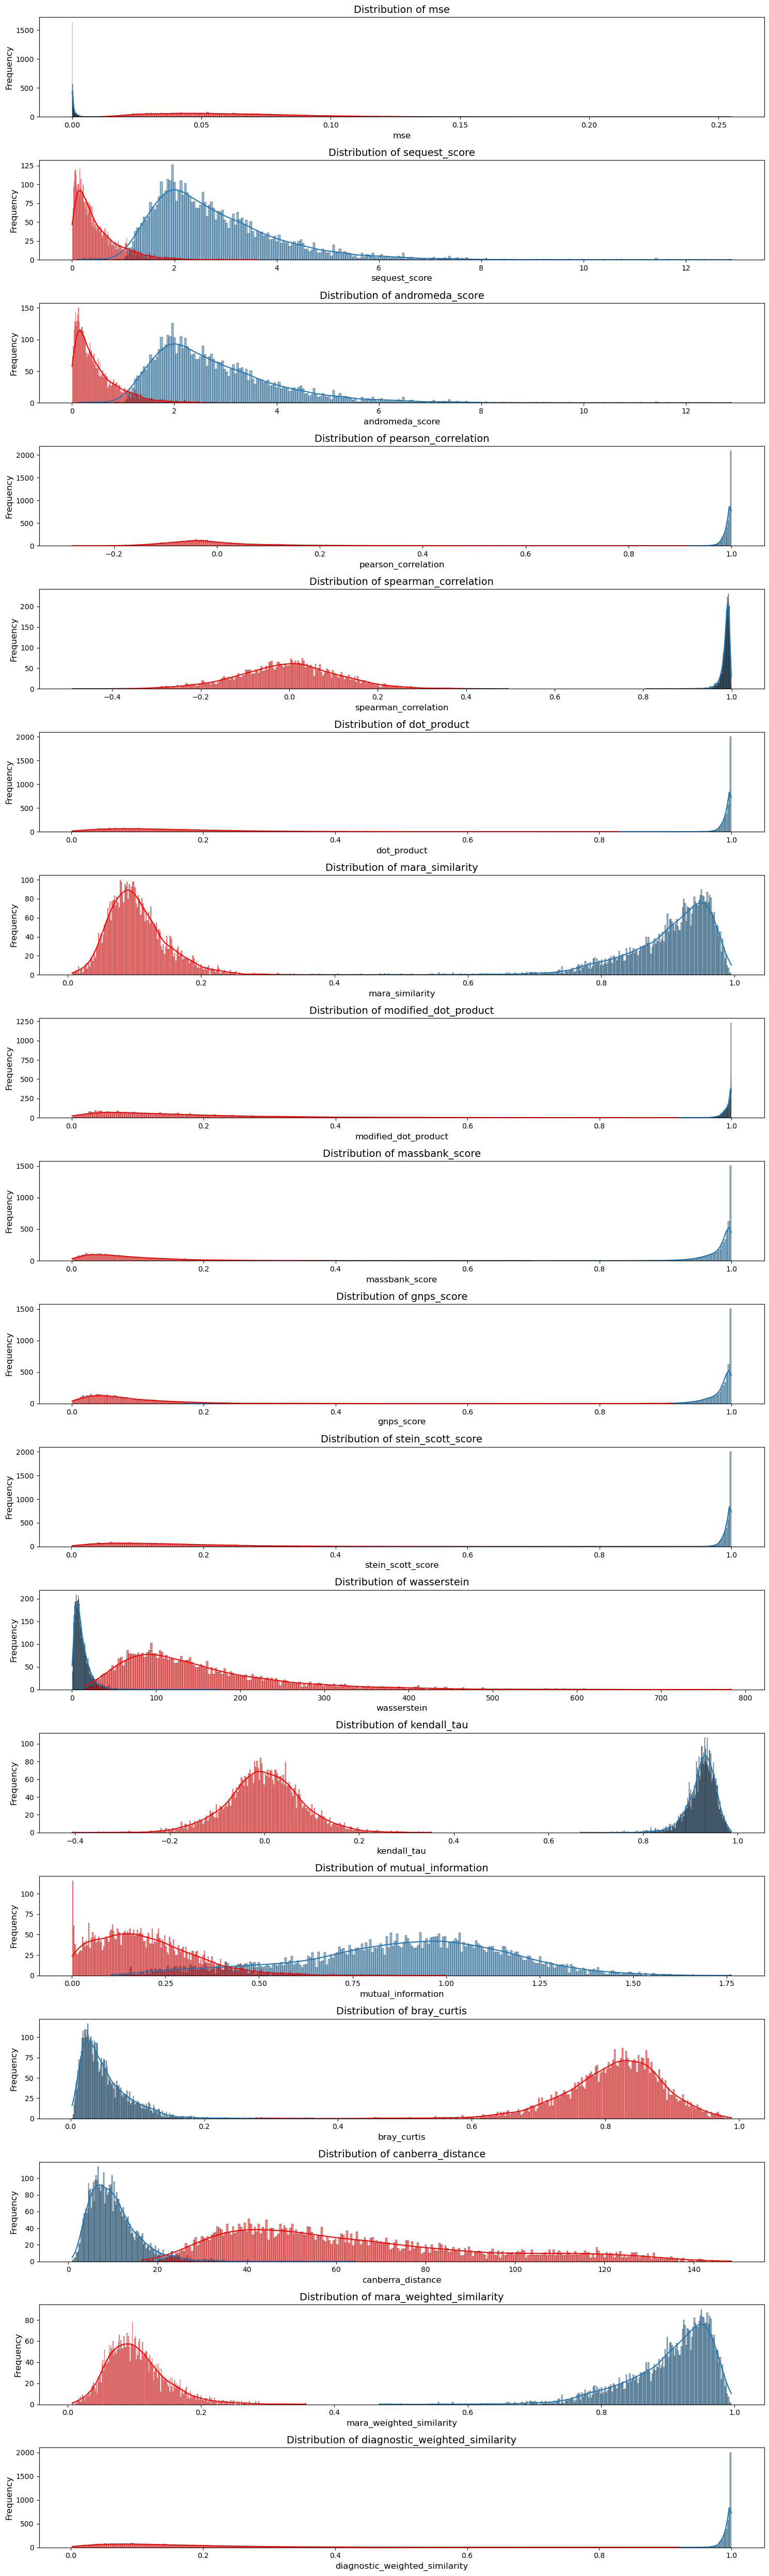

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the distributions for each score as histograms
score_columns = score_df.columns

# Set plot size and style
plt.figure(figsize=(15, 50))
for idx, col in enumerate(score_columns, 1):
    plt.subplot(len(score_columns), 1, idx)
    sns.histplot(score_df[col], bins=300, kde=True)
    sns.histplot(score_df_randomized[col], bins=300, kde=True, color="red")
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()